# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
import datetime
from pyspark.sql.types import IntegerType
from pyspark.sql import Window
from pyspark.sql.functions import desc
from pyspark.sql.functions import sum as Fsum
import pyspark.sql.functions as sf
import pandas as pd
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler, PCA
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# from databricks import koalas as ks
# ! conda install koalas
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# create a Spark session
spark = SparkSession.builder.appName("SparkifyCapstone").getOrCreate()
spark.sparkContext.getConf().getAll()

[('spark.app.name', 'SparkifyCapstone'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.id', 'local-1590780480379'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', '36685b1360d4'),
 ('spark.driver.port', '38625'),
 ('spark.ui.showConsoleProgress', 'true')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
miniDataset = spark.read.json("mini_sparkify_event_data.json")

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [5]:
print(miniDataset.printSchema())
print(miniDataset.count())
print(miniDataset.take(1))

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

None
286500
[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117

In [6]:
print(miniDataset.select("page").distinct().sort("page").show())
print(miniDataset.select("status").distinct().sort("status").show())

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows

None
+------+
|status|
+------+
|   200|
|   307|
|   404|
+------+

None


In [7]:
# miniDataset.filter(miniDataset.userId != '').count()

# Dropping records with no userId
miniDataset = miniDataset.dropna(how = "any", subset = ["userId", "sessionId"])
miniDataset = miniDataset.filter(miniDataset.userId != '')

In [8]:
# Define churn
churn_flag = udf(lambda x: 1 if x =='Cancellation Confirmation' else 0, IntegerType())
miniDataset = miniDataset.withColumn("churn", churn_flag(miniDataset.page))

In [9]:
# to_datetime = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0))
# miniDataset = miniDataset.withColumn("ts", to_datetime(miniDataset.ts))
# miniDataset.take(2)
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
miniDataset = miniDataset.withColumn("hour", get_hour(miniDataset.ts))
songs_in_hour = miniDataset.filter(miniDataset.page == "NextSong").groupby(miniDataset.hour).count().orderBy(miniDataset.hour.cast("float"))


In [10]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

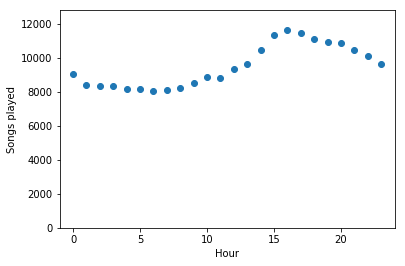

In [11]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.1 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

In [12]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
miniDataset = miniDataset.withColumn("stayed", Fsum("churn").over(windowval))

print('### Activites for those who stayed ###')
# print(miniDataset.select(["userId", "page", "level","churn"]).where(miniDataset.churn < 1).groupBy(['page','level']).count().orderBy('level').show(10000))
print(miniDataset.select(["userId", "page", "level","churn","stayed"]).where(miniDataset.stayed < 1).groupBy(['page']).count().orderBy('page').show(10000))

print('### Activites for those who churned ###')
print(miniDataset.select(["userId", "page", "level","churn","stayed"]).where(miniDataset.stayed > 0).groupBy(['page']).count().orderBy('page').show(10000))

### Activites for those who stayed ###
+----------------+------+
|            page| count|
+----------------+------+
|           About|   439|
|      Add Friend|  3641|
| Add to Playlist|  5488|
|       Downgrade|  1718|
|           Error|   220|
|            Help|  1215|
|            Home|  8410|
|          Logout|  2673|
|        NextSong|191714|
|     Roll Advert|  2966|
|   Save Settings|   252|
|        Settings|  1244|
|Submit Downgrade|    54|
|  Submit Upgrade|   127|
|     Thumbs Down|  2050|
|       Thumbs Up| 10692|
|         Upgrade|   387|
+----------------+------+

None
### Activites for those who churned ###
+--------------------+-----+
|                page|count|
+--------------------+-----+
|               About|   56|
|          Add Friend|  636|
|     Add to Playlist| 1038|
|              Cancel|   52|
|Cancellation Conf...|   52|
|           Downgrade|  337|
|               Error|   32|
|                Help|  239|
|                Home| 1672|
|              Logout

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [13]:
# As a first feature I will do the count of each page for each user to create a feature per page identified
pageColumns = [x[0] for x in miniDataset.select("page").distinct().sort("page").collect()]
print('Total number of features: ',len(pageColumns))

Total number of features:  19


In [14]:
dfFeatures = miniDataset.select('userId','churn').groupBy('userId').agg(Fsum('churn').alias('label'))
print(dfFeatures.show(10))
print(dfFeatures.count())

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|    51|    1|
|   124|    0|
|     7|    0|
|    54|    1|
|    15|    0|
|   155|    0|
|   132|    0|
+------+-----+
only showing top 10 rows

None
225


In [15]:
# Getting all pages names and excluding those dealing with cancelations
featureCols = []
for feature in pageColumns:
    # excluding pages that might be dedundant with churn label
    if feature not in ['Cancel']:
#     if feature not in ['Cancel','Cancellation Confirmation']:
        tempdf = miniDataset.select('userId','page').groupBy('userId','page').count().\
            select('userId',sf.col("count").alias(feature)).where(miniDataset.page == feature)
        dfFeatures = dfFeatures.join(tempdf, dfFeatures.userId == tempdf.userId, 'left').drop(tempdf.userId)
        featureCols.append(feature)
    #     print(dfFeatures.join(tempdf, dfFeatures.userId == tempdf.userId, 'inner').drop(tempdf.userId).count())

dfFeatures.count()

225

In [16]:
# filling na/null values with zero
dfFeatures = dfFeatures.na.fill(0)
dfFeatures.show(3)

+-----+------+-----+----------+---------------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|label|userId|About|Add Friend|Add to Playlist|Cancellation Confirmation|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|
+-----+------+-----+----------+---------------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|    0|100010|    1|         4|              7|                        0|        0|    0|   2|  11|     5|     275|         52|            0|       0|               0|             0|          5|       17|      2|
|    0|200002|    3|         4|              8|                        0|        5|    0|   2|  20|     5|     387|          7|            0|       

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [17]:
# Creating features vector for normalization methods/functions
assembler = VectorAssembler(inputCols=featureCols, outputCol="Features")
dfFeatures = assembler.transform(dfFeatures)

In [18]:
# Checking assembler transformation
dfFeatures.show(3,False)

+-----+------+-----+----------+---------------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+----------------------------------------------------------------------------------------+
|label|userId|About|Add Friend|Add to Playlist|Cancellation Confirmation|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|Features                                                                                |
+-----+------+-----+----------+---------------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+----------------------------------------------------------------------------------------+
|0    |100010|1    |4         |7              |0                        |0        |0    |2   |

In [19]:
# normalize data using Normalizer
scaler = Normalizer(inputCol="Features", outputCol="normalizedFeatures")
dfFeatures = scaler.transform(dfFeatures)

In [20]:
# normalize data using StandardScaler
scaler = StandardScaler(inputCol="Features", outputCol="scaledFeatures", withStd=True)
scalerModel = scaler.fit(dfFeatures)
dfFeatures = scalerModel.transform(dfFeatures)

In [21]:
# Applying PCA (to remove correlated features and shrink the features space by about half) to both normalized features 
pcaNorm = PCA(k=8, inputCol="normalizedFeatures", outputCol="pcaNormFeatures")
model = pcaNorm.fit(dfFeatures)
dfFeatures = model.transform(dfFeatures)

pcaScaled = PCA(k=8, inputCol="scaledFeatures", outputCol="pcaScaledFeatures")
model = pcaScaled.fit(dfFeatures)
dfFeatures = model.transform(dfFeatures)

In [22]:
# Logistic Regression using features with PCA and Spark Normilizer
data = dfFeatures.select(dfFeatures.label.alias("label"), dfFeatures.pcaNormFeatures.alias("features"))
trainNorm, validationNorm = data.randomSplit([0.9, 0.1], seed=42)
trainNorm = trainNorm.cache()
lr =  LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[0.0, 0.1,0.5,1.0]) \
    .addGrid(lr.regParam,[0.0, 0.05, 0.1]) \
    .build()

#     .addGrid(lr.elasticNetParam,[0.0, 0.1, 0.5]) \

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_lrNorm = crossval.fit(trainNorm)
print(cvModel_lrNorm.avgMetrics)

##### Saved this since it takes a while to process #####
# [0.7241808689994005, 0.693360617416807, 0.6838585589421972, 0.7241808689994005, 0.693360617416807, 
# 0.6838585589421972, 0.7241808689994005, 0.6838585589421972, 0.6838585589421972, 0.7241808689994005, 
# 0.6838585589421972, 0.6838585589421972]

[0.719360067962531, 0.6909219002664337, 0.6811902236277637, 0.719360067962531, 0.6909219002664337, 0.6834720475906559, 0.719360067962531, 0.6938087034416291, 0.6834720475906559, 0.719360067962531, 0.6834720475906559, 0.6834720475906559]


In [23]:
# Logistic Regression using features with PCA and Spark StandardScaler
data = dfFeatures.select(dfFeatures.label.alias("label"), dfFeatures.pcaScaledFeatures.alias("features"))
trainScaled, validationScaled = data.randomSplit([0.9, 0.1], seed=42)
trainScaled = trainScaled.cache()
lr =  LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[0.0, 0.1, 0.5, 1.0]) \
    .addGrid(lr.regParam,[0.0, 0.05, 0.1]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_lrScaled = crossval.fit(trainScaled)
print(cvModel_lrScaled.avgMetrics)

##### saved results since this takes a long time process #####
# [0.6828479514058365, 0.6741802559543306, 0.6814972603226915, 0.6828479514058365, 
#  0.6765677674327513, 0.6814972603226915, 0.6828479514058365, 0.6814972603226915, 
#  0.6838427184821032, 0.6828479514058365, 0.6838427184821032, 0.6838427184821032]

[0.9011405442473007, 0.9011405442473007, 0.9011405442473007, 0.9011405442473007, 0.9011405442473007, 0.9011405442473007, 0.9011405442473007, 0.9011405442473007, 0.9011405442473007, 0.9011405442473007, 0.8967540834224836, 0.889943020192979]


In [24]:
# Since the PCA with Normilizer model privided better results, below f1 is computed using that model
# and validation set
results = cvModel_lrNorm.transform(validationNorm)

In [25]:
# get f1 score for Normalized features model
tp = results.filter("label = 1 and prediction = 1").count()
fp = results.filter("label = 0 and prediction = 1").count()
fn = results.filter("label = 1 and prediction = 0").count()
print(tp,fp,fn)
precision = tp / (tp + fp) 
recall = tp / (tp + fn)
f1 = 2*precision*recall / (precision+recall)
print(precision)
print(recall)
print(f1)

1 0 6
1.0
0.14285714285714285
0.25


In [26]:
results = cvModel_lrScaled.transform(validationScaled)

In [27]:
# get f1 score for Scaled features model
tp = results.filter("label = 1 and prediction = 1").count()
fp = results.filter("label = 0 and prediction = 1").count()
fn = results.filter("label = 1 and prediction = 0").count()
print(tp,fp,fn)
precision = tp / (tp + fp) 
recall = tp / (tp + fn)
f1 = 2*precision*recall / (precision+recall)
print(precision)
print(recall)
print(f1)

4 0 3
1.0
0.5714285714285714
0.7272727272727273


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

### Conclusion
For the purpose of this excercise, I went ahead and applied a range of different parameters, using Logistic Regression, but under different sets of notmilized features. One with Normilizer and PCA, and the otherone with StandardScaler. This just to not only see the results of logistic regression model, but also see what the impact can be if features are normilized in different ways. Also, I was very interested in the potential of PCA, and how it can reduce the feature space, by removing those features that could potentially be correlated. 